In [21]:
####################################################
# This is a scratchpad for analysis of intermediate results in the CGMBrush library.
####################################################

# NOTE: Always clear results before checking in a jupyter notebook. This improves diff's.

from cgmbrush.cgmbrush import *
import matplotlib.colors as colors
from cgmbrush.cosmology import cosmology as cosmo
from cgmbrush.cosmology import halo as halo
import numpy as np
%matplotlib inline
from memory_profiler import profile


ERROR: Could not find file C:\Users\ianw8\AppData\Local\Temp/ipykernel_9552/2196477109.py


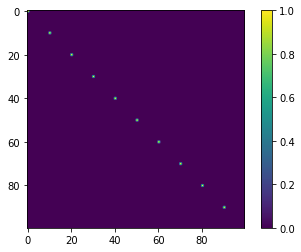

In [22]:
@profile
def setup():
    r = 1
    size = 100 * r
    a = np.zeros((size,size))
    a[(np.arange(0,size,step=10), np.arange(0,size,step=10))] = 1

    b = np.ones((6*r,6*r))

    return a,b

a,b = setup()
plt.imshow(a)
plt.colorbar()

3


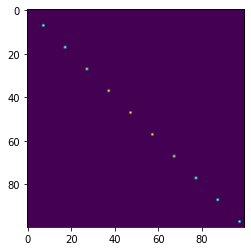

In [15]:

halfwidth = int(b.shape[0] / 2)
print(halfwidth)
a2 = np.roll(np.roll(a, -halfwidth, axis=0), -halfwidth, axis=1)
plt.imshow(a2)


Filename: c:\Users\ianw8\OneDrive\Documents\GitHub\cgm-brush\cgmbrush\cgmbrush.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   375   4121.6 MiB   4121.6 MiB           1   @profile
   376                                         def my_convolve(a, b):
   377                                             """FFT convolve. Assumes a is the bigger 2D array and b is the smaller 2D mask."""
   378   4121.6 MiB      0.0 MiB           1       halfwidth = int(b.shape[0] / 2)
   379   4121.6 MiB      0.0 MiB           1       a2 = np.roll(np.roll(a, -halfwidth, axis=0), -halfwidth, axis=1)
   380   4121.6 MiB      0.0 MiB           1       return np.fft.irfft2(np.fft.rfft2(a2) * np.fft.rfft2(b, a2.shape))




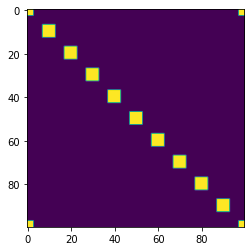

In [17]:
results = my_convolve(a,b)
plt.imshow(results)

In [ ]:
###################################################
# Profile Mask Visualizer
###################################################
def view_mask(profile: CGMProfile, mass):

    provider = BolshoiProvider()

    # pick some parameters
    redshift = 0 
    resolution = 16
    cellsize = provider.Lbox / (provider.halofieldresolution * resolution)
    print("cellsize (kpc): %s" % (cellsize * 1000))
    fine_mask_len = 20 * resolution
    fine_mask_len_small = 2 * resolution

    comoving_rvir = halo.comoving_rvir(cosmo, mass, redshift)
    print("co-moving virial radius (kpc): %s" % (comoving_rvir * 1000))

    mask = profile.get_mask(mass, comoving_rvir, redshift, resolution, 1, cellsize, fine_mask_len)
    mask_small = profile.get_mask(mass, comoving_rvir, redshift, resolution, 1, cellsize, fine_mask_len_small)
    fig, ax = plt.subplots(1,2,figsize=(24, 12))
    pos = ax[0].imshow(mask)
    pos = ax[1].imshow(mask_small)
    ax[0].title.set_text('{} Profile, M=${:.1e}$'.format(profile.name, mass))
    ax[1].title.set_text('{} Profile (zoomed), M=${:.1e}$'.format(profile.name, mass))
    fig.colorbar(pos, ax=ax)

# Choose a profile and mass
view_mask(FireProfile(), 1E10) 
view_mask(FireProfile(), 1E14) 
view_mask(NFWProfile(), 1E10) 
view_mask(NFWProfile(), 1E14) 

In [ ]:
from cgmbrush import *
def compareRadii(mass, z):
    print("Mass {:.1e}, z={}".format(mass, z))
    a = halo.comoving_rvir(cosmo, mass, z)
    b = halo.r200Mz(cosmo, mass, z)
    print('  rVir:\t{:.4f} Mpc'.format(a))
    print('  r200:\t{:.4f} Mpc'.format(b))
    print('  difference:\t{:.1f}%'.format((abs(b-a)) * 100 / b))

masses = [1E10,1E13,1E15]
redshifts = [0,0.5,1,2]

for z in redshifts:
    for m in masses:
        compareRadii(m, z)

In [ ]:
####################################################
# Get a feel for halo masses for the simulation
####################################################
p = BolshoiProvider()
halos = p.get_halos(0)
print('Max: {:.2e}'.format(max(halos['Mvir'])))
print(np.percentile(halos['Mvir'], [50,80,95,99,99.9,99.99,99.999]))


In [ ]:
###################################################################################################
#Simplified code that calculates the mass within the analytic profile 
#Currently it does this for fire and percipitation but can be easily generalized
#
#The vertical lines are the virial radius
###################################################################################################
from cgmbrush.cgmbrush import *
%matplotlib inline
import numpy as np
import cgmbrush.plots.plotting_routines as makefig

redshift = 0
#df = provider.get_halos(redshift)
#df, bin_markers = create_halo_array_for_convolution(df, 10**10, 9*10**15, 30)

massfactor =   1/cosmo.fb*mu*mprot/msun*(Mpc)**3

fp = FireProfile()
percip = PrecipitationProfile()
color = ['black','red', 'orange', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'brown']
nummass=6
i=0
for Mvir_avg in np.logspace(10, 15, nummass):

    rvir = halo.comoving_rvir(cosmo, Mvir_avg, redshift)
    rvalsFire, densityFire = fp.get_analytic_profile(Mvir_avg, redshift)
    rvalsPercip, densityPercip = percip.get_analytic_profile(Mvir_avg, redshift)


    totalmassanalyticFire = 4.*np.pi*np.sum(rvalsFire[1:]**2*densityFire[1:] *(rvalsFire[1:] - rvalsFire[:-1]))
    totalmassanalyticPercip = 4.*np.pi*np.sum(rvalsPercip[1:]**2*densityPercip[1:]*(rvalsPercip[1:] - rvalsPercip[:-1]))
    
    totalmassanalyticFire *= massfactor
    totalmassanalyticPercip *= massfactor
    print(np.log10(Mvir_avg), "massFire in 1e12 = ", totalmassanalyticFire/1e12, " truth = ", Mvir_avg/1e12, " ratio =", totalmassanalyticFire/Mvir_avg)
    print(np.log10(Mvir_avg), "massPercip in 1e12 = ", totalmassanalyticPercip/1e12,  " truth = ",  Mvir_avg/1e12,  " ratio =", totalmassanalyticPercip/Mvir_avg)
    

    plt.loglog(rvalsFire, densityFire, color=color[i%nummass])
    plt.loglog(rvalsPercip, densityPercip, '--', color=color[i%nummass])
    plt.axvline(rvir, color=color[i%nummass])
    i+=1
        

plt.xlim([.01,3])